In [1]:
import pandas as pd 
import numpy as np 
from os.path import join as os_join
import json
import os
import pprint
import matplotlib.pyplot as plt
import pickle
pp = pprint.PrettyPrinter(width=41, compact=True)
# white, professional/manager, US vs non-US, workclass (gov vs private)


In [8]:
%pwd

'/home/giorgian/Documente/Cercetare/Fairness/nn_fairness'

# 0. Model input:
```
x = [age_feat, edu_feat, hours_per_week_feat, sex_feat, race_white_black_feat, country_is_native_feat, occupation_managerial_feat, occupation_is_gov_feat]
y = [ is_greater_than_50K ]
```

```
age             :       normalized to [0,1], original max: 90 , original min: 17
edu_num         :       normalized to [0,1], original max: 16 , original min: 1
hours_per_week  :       normalized to [0,1], original max: 99 , original min: 1
is_male         : 1.0 means male, 0.0 means female,
race-related:   : 1.0 means black, 0.0 means white,
native_immigrant: 1.0 means American, 0.0 means not,
managerial_feat : 1.0 means management job, 0.0 means not,
gov_feat        : 1.0 means government job,

is_greater_than_50K: Binary indictor

```



# 1. Data distribution

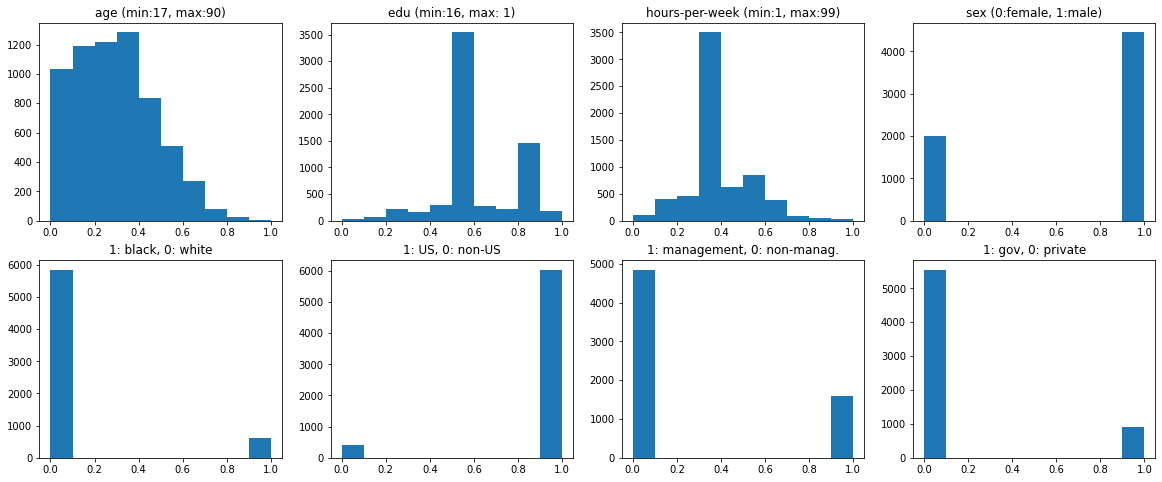

In [9]:
    
cache_path = 'NN-verification/cache'
random_seed = 0
cache_file_path = os_join(cache_path,f'np-adult-data-v2-rs={random_seed}.pkl')
with open(cache_file_path, 'rb') as f:
    data_dict = pickle.load(f)
X_train = data_dict["X_train"]
y_train = data_dict["y_train"]
X_dev = data_dict["X_dev"]
y_dev = data_dict["y_dev"]
X_test = data_dict["X_test"]
y_test = data_dict["y_test"]
input_shape = X_train.shape[1]

# testing data distribution:
age_feat = (X_test[:,0],'age (min:17, max:90)')
edu_feat = (X_test[:,1],'edu (min:16, max: 1)')
hours_wk_feat = (X_test[:,2],'hours-per-week (min:1, max:99)')
sex_feat = (X_test[:,3],'sex (0:female, 1:male)')
race_feat = (X_test[:,4],'1: black, 0: white')

us_feat = (X_test[:,5],'1: US, 0: non-US')
manag_feat = (X_test[:,6],'1: management, 0: non-manag.')
gov_feat = (X_test[:,7], '1: gov, 0: private')


plot_data = [age_feat, edu_feat, hours_wk_feat, sex_feat, race_feat, us_feat, manag_feat, gov_feat]
fig, axs = plt.subplots(2,4, figsize =(20,8))
axs = axs.flatten()
for (_d, _text), ax in zip(plot_data, axs):
    ax.hist(_d)
    ax.set_title(_text)
    
    
# ax = axs[4]
# axis_text = ['White', 'Black', 'Asian-Pac-Islander','Amer-Indian-Eskimo', 'Other']
# ax.barh(axis_text, race_feat[0])
# ax.set_title(race_feat[1])
# ax.tick_params(axis='y', labelrotation = 45)
# fig.tight_layout()



# 2. Load Model
### 1. Change res_root_path to the correct path, Something like: 
```
res_root_path = '/Users/xingzhiguo/Documents/git_project/NN-verification/results'
```


In [10]:
res_root_path = 'NN-verification/results'

In [11]:
def tell_me_model(random_seed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config):
    res_root_path = 'NN-verification/results'
    max_epoch = 10
    train_bs = 32
    # eval_bs = 128
    # lr = 0.01
    model_save_dir = os_join(res_root_path, f'adult-v2-model_config-{model_config}-max_epoch={max_epoch}-train_bs={train_bs}-random_seed={random_seed}-is_random_weight-{is_random_weight}-race_permute={is_race_permute}-sex_permute={is_sex_permute}-both_sex_race_permute={is_sex_race_both_permute}')
    onnx_file_path = os_join(model_save_dir, 'model.onnx')
    training_stats_file = os_join(model_save_dir, 'res-stats.json')
    # print (f'onnx is here: {onnx_file_path}' )
    # print (f'train-stats is here: {training_stats_file}' )
    
    with open(training_stats_file, 'r') as f:
        line = f.readline()
        train_stats = json.loads(line)
        # pp.pprint(train_stats)
    return [onnx_file_path], [train_stats]

def tell_me_model_aug_fair_train(random_seed, is_race_permute, is_sex_permute, is_sex_race_both_permute, 
                is_random_weight, 
                is_fair_train_remove_sym_diff,
                is_fair_train_flip_duplicate_sym_diff,
                is_fair_train_iter_flip_duplicate_sym_diff,
                model_config):
    res_root_path = 'NN-verification/results'
    max_epoch = 10
    train_bs = 32
    # eval_bs = 128
    # lr = 0.01
    model_save_dir = os_join(res_root_path, f'adult-v2-model_config-{model_config}-max_epoch={max_epoch}-train_bs={train_bs}-random_seed={random_seed}-is_random_weight-{is_random_weight}-race_permute={is_race_permute}-sex_permute={is_sex_permute}'+
                                    f'-both_sex_race_permute={is_sex_race_both_permute}-is_fair_rmv_sym_diff={is_fair_train_remove_sym_diff}-is_fair_copy_sym_diff={is_fair_train_flip_duplicate_sym_diff}-is_fair_iter_copy_sym_diff={is_fair_train_iter_flip_duplicate_sym_diff}')
    #onnx_file_path = os_join(model_save_dir, 'model.onnx')
    #training_stats_file = os_join(model_save_dir, 'res-stats.json')
    #print (f'onnx is here: {onnx_file_path}' )
    #print (f'train-stats is here: {training_stats_file}' )
    
    # with open(training_stats_file, 'r') as f:
    #     line = f.readline()
    #     train_stats = json.loads(line)
    #     pp.pprint(train_stats)
    training_stats_files = []
    
    onnx_file_path_list, train_stats_list = [], []
    for K in range(10):
        _ = os_join(model_save_dir, f'res-stats-iter-{K}.json')
        onnx_file = os_join(model_save_dir, f'model-iter-{K}.onnx')
        if os.path.exists(_) is not True:
            break 
        else:
            training_stats_files.append(_)
            onnx_file_path_list.append(onnx_file)
    # print (len(training_stats_files))
    
    for _ in training_stats_files:
        with open(_,'r') as f :
            data = json.loads(f.readline())
            train_stats_list.append(data)
    #print(train_data)
    return onnx_file_path_list, train_stats_list


# Fetch the trained models with performance (auc) during train/val/test

In [12]:

model_summary = []

model_configs = ['small','medium']
num_random_seed = 5 # only repeat for once 
for model_config in model_configs:
    # normal model
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        res_dict = {'strategy': 'original', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)
        

    # race-permute only model
    is_race_permute = True 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        res_dict = {'strategy': 'race-permute', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)

    # remove sym diff instance
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    is_fair_train_remove_sym_diff = True
    is_fair_train_flip_duplicate_sym_diff = False
    is_fair_train_iter_flip_duplicate_sym_diff = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model_aug_fair_train(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, 
                is_random_weight, 
                is_fair_train_remove_sym_diff,
                is_fair_train_flip_duplicate_sym_diff,
                is_fair_train_iter_flip_duplicate_sym_diff,
                model_config)
        res_dict = {'strategy': 'Rmv-SymDiff', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)

    # augment sym diff instance
    is_race_permute = False 
    is_sex_permute =  False
    is_sex_race_both_permute = False
    is_random_weight = False
    is_fair_train_remove_sym_diff = False
    is_fair_train_flip_duplicate_sym_diff = True
    is_fair_train_iter_flip_duplicate_sym_diff = False
    for randseed in range(num_random_seed): 
        onnx_file_path_list, train_stats_list = tell_me_model_aug_fair_train(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, 
                is_random_weight, 
                is_fair_train_remove_sym_diff,
                is_fair_train_flip_duplicate_sym_diff,
                is_fair_train_iter_flip_duplicate_sym_diff,
                model_config)
        res_dict = {'strategy': 'Aug-SymDiff', 
                    'random_seed': randseed,
                    'model_size': model_config, 
                    'onnx_list':  onnx_file_path_list,
                    'model_stats':  train_stats_list,
                    }
        model_summary.append(res_dict)



    # random model
    # is_race_permute = False 
    # is_sex_permute =  False
    # is_sex_race_both_permute = False
    # is_random_weight = True
    # for randseed in range(num_random_seed):
    #     onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)

    # sex-permute only model
    # is_race_permute = False 
    # is_sex_permute =  True
    # is_sex_race_both_permute = False
    # is_random_weight = False
    # for randseed in range(num_random_seed): 
    #     onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
        
    # both-sex-race-permute only model
    # is_race_permute = False 
    # is_sex_permute =  False
    # is_sex_race_both_permute = True
    # is_random_weight = False
    # for randseed in range(num_random_seed): 
    #     onnx_file_path_list, train_stats_list = tell_me_model(randseed, is_race_permute, is_sex_permute, is_sex_race_both_permute, is_random_weight, model_config)
    
df_model_summary = pd.DataFrame.from_records(model_summary)
df_model_summary


,strategy,random_seed,model_size,onnx_list,model_stats
0,original,0,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.454640924930572...
1,original,1,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.470596313476562...
2,original,2,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.465927213430404...
3,original,3,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.459149479866027...
4,original,4,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.461203575134277...
5,race-permute,0,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.458186566829681...
6,race-permute,1,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.472323805093765...
7,race-permute,2,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.471831798553466...
8,race-permute,3,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.459811240434646...
9,race-permute,4,small,[NN-verification/results/adult-v2-model_config...,[{'train': {'loss_history': [0.461758255958557...


In [13]:
import copy
models = []
for model in model_summary:
    network_label_template = {
        'strategy': model['strategy'],
        'random_seed': model['random_seed'],
        'model_size': model['model_size'],
    }
    for iteration, (stats, onnx_filename) in enumerate(zip(model['model_stats'], model['onnx_list'])):
        network_label = copy.copy(network_label_template)
        network_label['iteration'] = iteration
        network_label = json.dumps(network_label)
        auc = stats['test']['auc_history'][0]
        models.append((network_label, onnx_filename, auc))
        
config = {
    'train_data_path': cache_file_path,
    'class_1': {
        'indices': [4, 3],
        'values': [0],
        'label': 'White Male',
        'box': [
            [0.0, 1.0], # age
            [0.0, 1.0], # education
            [0.0, 1.0], # hours worked
            [1.0, 1.0], # sex
            [0.0, 0.0], # race
            [0.0, 1.0], # native
            [0.0, 1.0], # manager
            [0.0, 1.0], # government
        ]
    },
    'class_2': {
        'indices': [4, 3],
        'values': [1],
        'label': 'Black Male',
        'box': [
            [0.0, 1.0], # age
            [0.0, 1.0], # education
            [0.0, 1.0], # hours worked
            [1.0, 1.0], # sex
            [1.0, 1.0], # race
            [0.0, 1.0], # native
            [0.0, 1.0], # manager
            [0.0, 1.0], # government
        ]
    },
    'discrete_indices': [4, 5, 6],
    'continuous_indices': [0, 1, 2],
    'models': models
}

with open('config.json', 'w') as handle:
    json.dump(config, handle)

# Pick an index to plot train/val/testing curve

In [32]:
picked_index = 37# the second row from above table

_df_model = df_model_summary.iloc[picked_index]
model_files = _df_model['onnx_list']
train_stats = _df_model['model_stats']
print (model_files) # may have one, or more than one (k-iter for augmented based on SD)
print(train_stats) # may have one, or more than one (k-iter for augmented based on SD)

_df = pd.DataFrame.from_records(train_stats)
_df['test_auc'] = [_['auc_history'][0] for _ in _df['test']]
display_df = None
if 'num_train' in _df.columns:
    display_df = _df[['num_train','test_auc']]
else:
    display_df = _df[['test_auc']]
display_df

['/Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-v2-model_config-medium-max_epoch=10-train_bs=32-random_seed=2-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False-is_fair_rmv_sym_diff=False-is_fair_copy_sym_diff=True-is_fair_iter_copy_sym_diff=False/model-iter-0.onnx', '/Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-v2-model_config-medium-max_epoch=10-train_bs=32-random_seed=2-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False-is_fair_rmv_sym_diff=False-is_fair_copy_sym_diff=True-is_fair_iter_copy_sym_diff=False/model-iter-1.onnx', '/Users/xingzhiguo/Documents/git_project/NN-verification/results/adult-v2-model_config-medium-max_epoch=10-train_bs=32-random_seed=2-is_random_weight-False-race_permute=False-sex_permute=False-both_sex_race_permute=False-is_fair_rmv_sym_diff=False-is_fair_copy_sym_diff=True-is_fair_iter_copy_sym_diff=False/model-iter-2.onnx', '/Users/xingzhi

,num_train,test_auc
0,30121,0.835102
1,31572,0.821858
2,34047,0.799700
3,35039,0.816134
4,36160,0.816841
5,39757,0.819494
6,45439,0.825899
7,49674,0.799748
8,51147,0.835404
9,53853,0.541039
